<a href="https://colab.research.google.com/github/laggyperson/URAP-Colab-ML-Notebooks/blob/main/DNN_MNIST_(with_notes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os # For saving the model
import cv2 # For importing images
import numpy as np
import matplotlib as plt

Step 1: Creating Input Pipeline

In [ ]:
# Normal import of data
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True, # For larger datasets stored in multiple files, best to shuffle files
    as_supervised=True, # Returns tuple instead of dictionary (img, label) vs {'image': image, 'label', label}
    with_info=True, # Returns an info variable that describes the dataset
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# ============================= ASIDE ===============================
# Loading Data Performance tests
#ds = tfds.load('mnist', split='train').batch(32).prefetch(buffer_size=64)
# Displaying benchmark stats. Specify batch size for normalizing results
#tfds.benchmark(ds)
# Doing it again is faster because of auto-caching
# Auto-caching only occurs if total dataset size is defined and < 250 MiB and (shuffle_files disabled or single shard read)
#tfds.benchmark(ds, batch_size=32)
# Manual Caching (for multiple iterations over dataset (want random order))
#ds = ds.cache()
# Good practice to shuffle batches (each epoch) and the buffer over the full dataset
#ds = ds.shuffle(ds_info.splits['train'].num_examples)
#ds = ds.batch(128)
#ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Building a training pipeline: Split the data into training and test sets as well as batches within each training set (for different epochs)
# TFDS imgs type tf.uint8, but model expects tf.float32 --> Convert and normalize images
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Cache before shuffling
ds_train = ds_train.cache()
# Shuffle buffer over entire dataset for true randomness (buffer_size=1000 for datasets that can't fit in mem and if system allows it)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# Batch dataset after shuffling to get training data for each epoch
ds_train = ds_train.batch(128)
# Prefetch to end pipeline for performance
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Evaluation Pipeline (testing dataset)
# No shuffling needed
# Normalize data like before
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)
# Batch the data
ds_test = ds_test.batch(128)
# Cache after batching because it is ok to repeat batches in each epoch
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Step 2: Creating and Training Model

In [ ]:
# Creating a Keras Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)), # Specifies input
  tf.keras.layers.Dense(128, activation='relu'), # Specifies a single layer with 128 nodes and a Regressive Linear activation function
  tf.keras.layers.Dense(10) # Final output layer
])

# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Training the model
# model.fit(
#     ds_train, # Dataset
#     epochs=10, # Number of training cycles
#     validation_data=ds_test
# )

In [ ]:
# Printing out model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


3. Saving and Using the Model

In [ ]:
# Saving the model with checkpoints
checkpoint_path = "test1/mnist_model_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Creating a callback that saves the model weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=5*batch_size # Specifies freqeuncy
                                                 )
# Fitting the model with this callback
model.fit(ds_train,
          epochs=10,
          validation_data=ds_test,
          callbacks=[cp_callback])

Epoch 1/10
461/469 [============================>.] - ETA: 0s - loss: 0.3672 - sparse_categorical_accuracy: 0.8977
Epoch 1: saving model to test1/mnist_model_cp.ckpt
469/469 [==============================] - 11s 11ms/step - loss: 0.3648 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2011 - val_sparse_categorical_accuracy: 0.9429
Epoch 2/10
466/469 [============================>.] - ETA: 0s - loss: 0.1682 - sparse_categorical_accuracy: 0.9525
Epoch 2: saving model to test1/mnist_model_cp.ckpt
469/469 [==============================] - 2s 5ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1415 - val_sparse_categorical_accuracy: 0.9584
Epoch 3/10
461/469 [============================>.] - ETA: 0s - loss: 0.1197 - sparse_categorical_accuracy: 0.9663
Epoch 3: saving model to test1/mnist_model_cp.ckpt
469/469 [==============================] - 2s 5ms/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.1085 - val_sparse_categorical_accuracy: 

In [ ]:
# Reloading the model from saved weights (need to have same architecture)
model_new = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)), # Specifies input
  tf.keras.layers.Dense(128, activation='relu'), # Specifies a single layer with 128 nodes and a Regressive Linear activation function
  tf.keras.layers.Dense(10) # Final output layer
])

# Compiling the model
model_new.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Untrained model test
loss, acc = model_new.evaluate(ds_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

79/79 - 1s - loss: 2.3930 - sparse_categorical_accuracy: 0.0770 - 1s/epoch - 16ms/step
Untrained model, accuracy:  7.70%


In [ ]:
# Reloading the model
model_new.load_weights(checkpoint_path)

# Re-evaluation
loss, acc = model.evaluate(ds_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

79/79 - 0s - loss: 0.0771 - sparse_categorical_accuracy: 0.9770 - 206ms/epoch - 3ms/step
Restored model, accuracy: 97.70%


In [ ]:
# Manually saving weights
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
# Saving the entire model as SavedModel type
!mkdir -p saved_model
model.save('./models/model1')

In [ ]:
# Reloading the model
new_model = tf.keras.models.load_model('./models/model1')

# Verifying
new_model.summary()

loss, acc = new_model.evaluate(ds_test, verbose=2)
print("Reloaded model, accuracy: {:5.2f}%".format(100 * acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
79/79 - 0s - loss: 0.0771 - sparse_categorical_accuracy: 0.9770 - 385ms/epoch - 5ms/step
Reloaded model, accuracy: 97.70%


1/1 [==============================] - 0s 241ms/step
[[-26.299393   -1.2915838  13.263046   10.007142  -36.381348   22.7725
  -18.81718    12.468726   -5.5735073 -10.957035 ]]


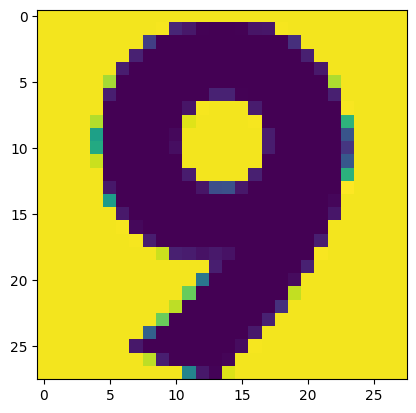

In [ ]:
# Testing model on image
image = cv2.imread('./test_img.png')
# Resizing image
dim = (28, 28)
image = cv2.resize(image, dim)
# Changing color channels to rgb
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Normalize
image = tf.cast(image, tf.float32) / 255.
image = image[:, :, 0]
plt.pyplot.imshow(image)
image_data = np.array(image)

tempimg = np.zeros((1, 28, 28))
tempimg[0] = image
image = tempimg

print(new_model.predict(image))

In [ ]:
print(ds_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
